In [50]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

# plt.style.use('ggplot')

import requests 
from urllib.parse import urlencode 

import pingouin as pg
from scipy.stats import levene
from scipy.stats import mannwhitneyu

In [11]:
#  Получение ссылки на скачивание и импорт данных
def get_url_disk(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    download_response = requests.get(download_url) 
    return download_url

public_key_hw_bootstrap = 'https://disk.yandex.ru/d/1TFOJ7Z80VAEFw'

hw_bootstrap = pd.read_csv(get_url_disk(public_key_hw_bootstrap), sep = ';')
hw_bootstrap

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [13]:
# приведение колонок к соответствующим типам данных
        # замена запятых на точки 
hw_bootstrap['value']= hw_bootstrap \
    ['value'] \
    .str.replace(',', '.')
        # приведение колонки value в формат числа с плавающей точкой 
hw_bootstrap = hw_bootstrap \
    .astype({'value' : 'float64'})
hw_bootstrap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1000 non-null   int64  
 1   value              1000 non-null   float64
 2   experimentVariant  1000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [17]:
# проверка на нули
check_null = hw_bootstrap.isnull().sum()
check_null

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

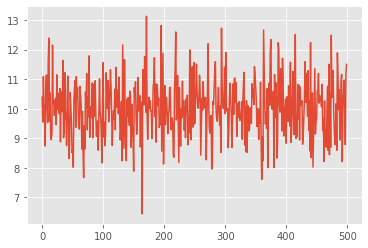

In [32]:
control = hw_bootstrap.query('experimentVariant == "Control"').value
control.plot()

Как видно, все значения группы контрольной группы колеблются вокруг значений 7-13 и сильных выбросов нет

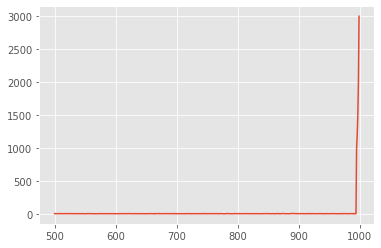

In [44]:
treatment = hw_bootstrap.query('experimentVariant == "Treatment"').value
treatment.plot()

значения конотрольной группы в целом также колеблются в диапазоне десятков, но также есть сильные выбросы

In [33]:
treatment.tail(10)

990      10.916229
991      11.160869
992       8.202518
993       9.782199
994      10.484967
995    1000.000000
996    1200.000000
997    1500.000000
998    2000.000000
999    3000.000000
Name: value, dtype: float64

Вот видно, что 5 последних значений выборки образуют сильно выбивающиеся выбросы, что естественно будет сильно влиять на среднее значение выборки

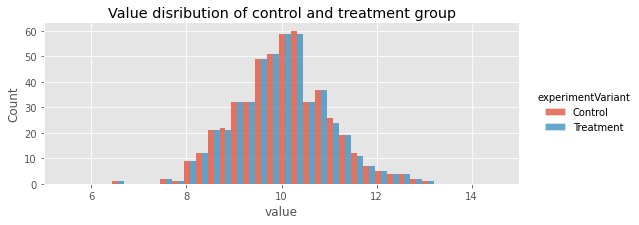

In [40]:
# посмотрим на распредление значений в тестовой и контрольной группе
#  в тестовой группе выбросы мешают оценить распределение основной массы значений, поэтомe оставим выбросы за границей гистограммы
sns.displot(hw_bootstrap, x = 'value', hue = 'experimentVariant', multiple="dodge", height=3, aspect=2.5) \
    .set(xlim = (5,15), 
        title = 'Value disribution of control and treatment group')

Из рисунка видно, что оба  распределения, исключая выбросы, похожи между собой и напоминаю нормальные. 

"На глаз" из этого распределения можно предположить, что верна нулвая гипотеза о равенстве средних. (Вообще "на глаз" можно сказать, что это одно и то же распределение за ислючением последних 5ти значений)

## T-тест

In [42]:
#  проверка на нормальность контрольной группы
pg.normality(control, method='normaltest')

,W,pval,normal
value,2.943459,0.229528,True


In [45]:
#  проверка на нормальность тестовой группы
pg.normality(treatment, method='normaltest')

,W,pval,normal
value,929.515767,1.439514e-202,False


Строго говоря, уже на этом этапе можно было бы отвергнуть Т-тест как не подходящий для наших выборок, т.к. не выполнено требование к нормальности, но продолжим, задание требует

In [54]:
# проверка на гомогенность дисперсий групп c помощью критерия Левена
stat, p1 = levene(control, treatment)
p1

0.03841703888538016

Небольшое значение p предполагает, что популяции не имеют одинаковой дисперсии. А значит и по этому критерию можно сказать, что Т-тест не подходит для наших выборок. Но продолжим.

In [49]:
#  сам Т-тест
pg.ttest(control, treatment)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.072902,998,two-sided,0.038438,"[-33.67, -0.92]",0.131102,0.586,0.544197


Согласно результату Т-теста вероятность обнаружить такие же или большие различия в средних значениях двух групп из предположения, что верна нулевая гипотеза о равенстве средних,  **очень мала (р < 0,05)**. 

Следовательно нужно отвергнуть нулевую гипотезу и признать, что между средними контрольной и тестовой группы удалось обнаружить статистически значимые различия. 

##  U-тест

In [56]:
pg.mwu(control, treatment)

,U-val,alternative,p-val,RBC,CLES
MWU,124189.5,two-sided,0.859215,0.006484,0.496758


Согласно результату U-теста p-value >> 0.05, поэтому принимаем нулевую гипотезу о равенстве средних

## Bootsrap средних

In [57]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

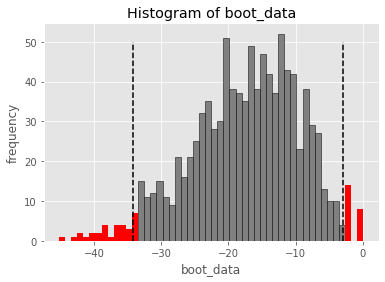

In [58]:
booted_data = get_bootstrap(control, treatment) # в результате хранится разница двух распределений, ДИ и pvalue

In [59]:
booted_data["p_value"] # альфа

0.03185120278630945

In [60]:
booted_data["quants"] # ДИ

,0
0.025,-34.212207
0.975,-2.997046


Согласно результату Bootstrapa p-value < 0.05, 95% доверительный интервал не включает 0, а следовательно можно отклонить нулевую гипотезу

И воотбще результат **Bootstrapa** очень хорошо согласуется с результатом **t-теста**, что в целом не удивительно, оба они работают с самими значениями, а не с их рангами и соответственно не устойчивы к выбросам.